In [1]:
#from pyAudioAnalysis import audioTrainTest as aT

In [2]:
#aT.extract_features_and_train(["classifierData/music","classifierData/speech"], 1.0, 1.0, aT.shortTermWindow, aT.shortTermStep, "svm", "svmSMtemp", False)
#aT.file_classification("audio-recognition/data/doremi.wav", "svmSMtemp","svm")


In [3]:
# adicionando parâmetros para evitar erros de arredondamento
import os

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'



# Importando bibliotecas para processamento
import keras

import tensorflow as tf
import os, sys, cv2, matplotlib.pyplot as plt, numpy as np, pandas as pd, pickle
import random
from random import seed, random, randint, sample

import tensorflow.keras as keras
from keras import backend as K
from keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, GlobalMaxPool1D, Activation, MaxPool1D, Conv1D, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import librosa ##### verificar bugs!!!!
import librosa.display
from sklearn.metrics import confusion_matrix, classification_report
from skimage.transform import resize
from scipy.signal import hilbert, chirp
from sklearn.preprocessing import MinMaxScaler
from librosa.filters import mel
import pywt
import scipy
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold



2024-11-03 20:37:08.340496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730677028.351951    1298 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730677028.356126    1298 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
#pip install tensorflow[and-cuda]   #bug relacionado ao tensorflow

/home/tathiana/jupyternb/audio-recognition
Escalas Ut:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Frequencias associadas   [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130.
  127.45098039  125.          122.64150943  120.37037037  118.1

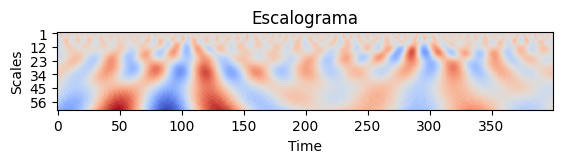

In [13]:
#exemplo isolado

filename = os.getcwd() + "/recordings/wav_headMic_F04S02_0152.wav"     #Audio retirado do dataset TORGO for disarthric speech <https://www.kaggle.com/datasets/pranaykoppula/torgo-audio?resource=download>
print(os.getcwd())

# leitura usando librosa(verificar obsolescência da biblioteca)!!!!
y, sr = librosa.load(filename)


wavelet = 'morl' # wavelet: morlet
sr = 8000 # Frequência amostral: 8KHz
widths = np.arange(1, 64) # escalas for morlet wavelet 
print("Escalas Ut: ", widths)
dt = 1/sr # passo de tempo

frequencies = pywt.scale2frequency(wavelet, widths) / dt # Get frequencies corresponding to scales
print("Frequencias associadas  ", frequencies)

#vetor com os coeficientes e frequencias associadas
wavelet_coeffs, freqs = pywt.cwt(y, widths, wavelet = wavelet, sampling_period=dt)
print("Formato da transformada Wavelet: ", wavelet_coeffs.shape)

# Plotagem do escalograma
plt.imshow(wavelet_coeffs[:,:400], cmap='coolwarm')
plt.xlabel("Time")
plt.ylabel("Scales")
plt.yticks(widths[0::11])
plt.title("Escalograma")
plt.show()

In [11]:
## Outro Código em processamento





# Import libraries
import os, sys, cv2, matplotlib.pyplot as plt, numpy as np, pandas as pd, pickle
import random
from random import seed, random, randint, sample

import tensorflow.keras as keras
from keras import backend as K
from keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, GlobalMaxPool1D, Activation, MaxPool1D, Conv1D, Flatten, BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import librosa 
import librosa.display
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import normalize
from mpl_toolkits.mplot3d import Axes3D
from skimage.transform import resize
from scipy.signal import hilbert, chirp
from sklearn.preprocessing import MinMaxScaler
from librosa.filters import mel
import pywt
import scipy
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold



# Step 1: Read the audio files and split into train/ test data


# The data in the current directory inside the doler "recordings".
dir = os.getcwd() + "/recordings/"
print(os.getcwd(), "DOne reading the recordings folder")
# Read audio files from the directory. For this tutorial, we will only classify 3 speakers: george, jackson, and lucas.
# Audio files have this format : {digit}_{speaker}_{speaker_filenumber}.wav

audio = [] # List to store audio np arrays
y = [] # List to store the target class labels

for root, dirs, files in os.walk(dir, topdown=False):    
    for name in files:

        if name.find(".wav") != -1 : # Check if the file has a .wav extension            
            if name.find("george") != -1 or name.find("jackson") != -1 or name.find("lucas") != -1 : # Check if the speaker is george, jackson, and lucas.
                fullname = os.path.join(root, name)
                audio.append(fullname) # Append the np array to the list.
                if name.find("george") != -1 :
                    y.append(0)
                elif name.find("jackson") != -1 :
                    y.append(1)
                else :
                    y.append(2)

# Write the audio data in a npz file so that we don't have to read the audio files again. We can load the data from npz file. Also, the npz format is very space efficient.
audio_train, audio_test, y_train, y_test = train_test_split(audio, y, test_size=0.3)
# np.savez_compressed(os.getcwd()+"/training_raw_audio", a=audio_train, b=y_train)
# np.savez_compressed(os.getcwd()+"/testing_raw_audio", a=audio_test, b=y_train)

print("Finished writing to npz file...")


print("Training Data class distribution: ", np.unique(y_train, return_counts=True))
print("Testing Data class distribution: ", np.unique(y_test, return_counts=True))



# carregando dados de treino e teste
train_data = np.load(os.getcwd()+"/training_raw_audio.npz", allow_pickle=True)
audio_train = train_data['a']
y_train = train_data['b']
print("Carregamento de dados de treino feito")

test_data = np.load(os.getcwd()+"/testing_raw_audio.npz", allow_pickle=True)
audio_test = test_data['a']
y_test = test_data['b']
print("carregamento de dados teste")




'''
Step 2: Write a function to compute continuous wavelet transform features of each audio sample
Human Voice Frequency Range:
- The human ear can hear between 20 and 20,000 Hz (20 kHz) but it is most sensitive to everything that happens between 250 and 5,000 Hz.
- The voiced speech of a typical adult male will have a fundamental frequency from 85 to 180 Hz, and that of a typical adult female from 165 to 255 Hz.
- For a child’s voice, average fundamental frequency is 300Hz.
- Consonants take up space between 2kHz and 5kHz.
- Vowel Sounds are prominent between 500Hz and 2kHz.

We will keep frequencies only between 80 Hz and 5KHz.
We will split each audio into frames of length 800.
'''

def compute_wavelet_features(X) :
    
    # Define a few parameters
    wavelet = 'morl' # wavelet type: morlet
    sr = 8000 # sampling frequency: 8KHz
    widths = np.arange(1, 256) # scales for morlet wavelet 
    dt = 1/sr # timestep difference

    frequencies = pywt.scale2frequency(wavelet, widths) / dt # Get frequencies corresponding to scales
    
    # Create a filter to select frequencies between 80Hz and 5KHz
    upper = ([x for x in range(len(widths)) if frequencies[x] > 1000])[-1]
    lower = ([x for x in range(len(widths)) if frequencies[x] < 80])[0]
    widths = widths[upper:lower] # Select scales in this frequency range

    # Compute continuous wavelet transform of the audio numpy array
    wavelet_coeffs, freqs = pywt.cwt(X, widths, wavelet = wavelet, sampling_period=dt)
    # print(wavelet_coeffs.shape)
    # sys.exit(1)

    # Split the coefficients into frames of length 800
    start = 0
    end = wavelet_coeffs.shape[1]
    frames = []
    frame_size = 400
    count = 0

    while start+frame_size <= end-1 :

        f = wavelet_coeffs[:,start:start+frame_size]        

        # Total samples in a frame will not be a multiple of 800 everytime. If the last frame length is less than 800, we can skip it.
        assert f.shape[1] == frame_size # assert frame lengths are equal to the frame_size parameter

        frames.append(f)
        start += frame_size


    # Convert frames to numpy array
    frames = np.array(frames)
    frames = frames.reshape((len(frames), wavelet_coeffs.shape[0], frame_size))

    return frames



# Step 3: Compute continuous wavelet transform of training and testing data using the function in Step 3

### Compute Training data features. We have each sample into frames of length 400

indices = []
WaveletFeatTrain = [] # Store wavelet features
WaveletYTrain = [] # Store class labels corresponding to wavelet features from an audio sample
uniq_id = []
count = 0

for i in range(3) :
    
    ind, = np.where(y_train == i)
    seed(i)
    ind = ind.tolist()
    ind = sample(ind, 100)
    audio_samples = audio_train[ind]
    num_rand_samp = 100

    for j in tqdm(range(len(audio_samples))) :

        # print("i ", i, " j ", j, "/", len(audio_samples))
        curr_sample = audio_samples[j]
        seq, _ = librosa.load(curr_sample) 
        F = compute_wavelet_features(seq)
        F = F.astype(np.float16)

        # Generate target labels corresponding to the frames of each sample
        indices = np.arange(0, len(F), 1)
        indices = indices.tolist()
        indices = sample(indices, min(num_rand_samp, len(indices)))
        F = F[indices]
        uniq_id += [count] * len(F)
        WaveletYTrain += [i] * len(F)

        if count == 0 :
            WaveletFeatTrain = F
        else :
            WaveletFeatTrain = np.concatenate((WaveletFeatTrain, F), axis=0) 
        
        count += 1


    
print("X: ", WaveletFeatTrain.shape)

WaveletYTrain = np.array(WaveletYTrain) # Convert to numpy array
uniq_id = np.array(uniq_id)
print("Y: ", WaveletYTrain.shape, " unique: ", np.unique(WaveletYTrain, return_counts=True))
# Write all features to a .npz file
np.savez_compressed(os.getcwd()+"/training_features", a=WaveletFeatTrain, b=WaveletYTrain, c=uniq_id)



### Compute Testing data features

WaveletFeatTest = [] # Store wavelet features. We have each sample into frames of length 400
WaveletYTest = [] # Store class labels corresponding to wavelet features from an audio sample
uniq_id = []

for i in tqdm(range(len(audio_test))) :

    curr_sample = audio_test[i]
    seq, _ = librosa.load(curr_sample) 
    curr_target = y_test[i]
    F = compute_wavelet_features(seq)

    # Generate target labels corresponding to the frames of each sample
    WaveletYTest += [curr_target] * len(F)
    uniq_id += [i] * len(F)

    if i == 0 :
        WaveletFeatTest = F
    else :
        WaveletFeatTest = np.concatenate((WaveletFeatTest, F), axis=0) 

WaveletYTest = np.array(WaveletYTest) # Convert to numpy array
uniq_id = np.array(uniq_id)
print("X: ", WaveletFeatTest.shape, "  y: ", WaveletYTest.shape)

WaveletFeatTest = WaveletFeatTest.astype(np.float16)

# Write all features to a .npz file
np.savez_compressed(os.getcwd()+"/testing_features", a=WaveletFeatTest, b=WaveletYTest, c=uniq_id)



# Step 4: Build a deep learning model
def create_model(row, col) :
    
    n_filters = 32
    filter_width = 3
    dilation_rates = [2**i for i in range(6)] * 2

    # define an input history series and pass it through a stack of dilated causal convolution blocks
    history_seq = Input(shape=(row, col))
    x = history_seq

    skips = []
    count = 0
    # x = GaussianNoise(0.01)(x)
    for dilation_rate in dilation_rates:

        # preprocessing - equivalent to time-distributed dense
        
        # filter
        x = Conv1D(filters=n_filters,
                    kernel_size=filter_width, 
                    padding='causal',
                    dilation_rate=dilation_rate, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(x)
    
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    out = Conv1D(16, 3, padding='same', kernel_initializer= 'random_normal', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(x)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = GlobalMaxPool1D()(out)

    out = Dense(3, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(out)
    out = Activation('softmax')(out)

    model = Model(history_seq, out)

    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

model = create_model(400, 76)
print(model.summary())






# Step 5: Preprocess the data and train the model
#For the neural network, we need the data in format: Num_samples x timesteps x features. But currently the data is in format: Num_samples x features x timesteps. 


# Load the data
training_data = np.load(os.getcwd()+"/training_features.npz")
X = training_data['a']
y = training_data['b']

X = X.transpose(0,2,1) # Put data in correct format: Num_samples x timesteps x features
y = to_categorical(y) # Convert class labels to categorial vectors
print("X ", X.shape, "y ", y.shape)

# Standardize the data
mean = X.mean()
std = X.std()
X = (X-mean)/ std

print("Mean ", mean, " STD ", std, X.mean(), X.std())

X = X.astype(np.float32)

y = y.astype(np.uint8)

print("Input shapes ", X.shape, y.shape)

# Write the standard deviation and mean in a pickle file
# f = open(os.getcwd()+'/speaker_mean_std.pkl', 'wb')
# pickle.dump([mean, std, y], f)
# f.close()

r,c = X[0].shape

# Split data into training and validation
X1, Xval, y1, yval = train_test_split(X, y, test_size=0.20)#, random_state=int(time.time()))

# Use 5-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True)

count = 0

# Train the model
# for train, test in kfold.split(X1, np.argmax(y1, axis= -1)):

#     print("K Fold Step  ", count)
#     model.fit(X1[train], y1[train], validation_data= (X1[test], y1[test]), batch_size= 128, epochs= 80, verbose= 2)
#     model.save(os.getcwd()+"/speaker_classifier.h5")

#     count += 1

#     scores = model.evaluate(Xval, yval, verbose=0)
#     print("Metrics : ", scores)




# Step 6: Test the model
model = load_model(os.getcwd()+"/speaker_classifier.h5", compile= False)

print(model.summary())

# Load the standard deviation and mean
f = open(os.getcwd()+'/speaker_mean_std.pkl', 'r+b')
mean, std, poss_knnn = pickle.load(f)
f.close()

testing_data = np.load(os.getcwd()+"/testing_features.npz")
X = testing_data['a']
y = testing_data['b']
ind = testing_data['c']
unq_ind = np.unique(ind)

X = X.astype(np.float32)

X = X.transpose(0,2,1) # Put data in correct format: Num_samples x timesteps x features
X = (X-mean)/ std

# Predict 
ypred = model.predict(X)
ypred = np.argmax(ypred, axis=-1)
ypred = ypred.flatten()

new_pred = []
new_truth = []

# Find unique ids and assign class based on majority vote from all the frames
for i in range(len(unq_ind)) :
    curr = unq_ind[i]
    indices, = np.where(ind == curr)
    t = y[indices]
    t = t[0]

    p = ypred[indices]    
    # p1 = ypred1[indices]    
    # p2 = ypred2[indices]    
    # p3 = ypred3[indices]    
    # p4 = ypred4[indices]    

    # all_model_pred = [get_best_candidate(x, t) for x in [p1, p2, p3, p4]]
    # un, fr = np.unique(all_model_pred, return_counts=True)

    un, fr = np.unique(p, return_counts=True)
    new_pred.append(un[np.argmax(fr)])
    print("Truth ", t, " Pred ", un, fr)

    new_truth.append(t)

new_truth = np.array(new_truth)
new_pred = np.array(new_pred)

# Print classification report
rep = classification_report(new_truth, new_pred, target_names=['speaker1', 'speaker2', 'speaker3'])
print(rep)

/home/tathiana/jupyternb/audio-recognition DOne reading the recordings folder
Finished writing to npz file...
Training Data class distribution:  (array([0, 1, 2]), array([696, 708, 696]))
Testing Data class distribution:  (array([0, 1, 2]), array([304, 292, 304]))
Carregamento de dados de treino feito
carregamento de dados teste


  0%|                                                                                           | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1298/215328331.py:168: UserWarning: PySoundFile failed. Trying audioread instead.
  seq, _ = librosa.load(curr_sample)
  0%|                                                                                           | 0/100 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: np.str_('/Users/adityadutt/Documents/Research/emotion_classify/WaveletTutorialImages/recordings/0_george_31.wav')